<a href="https://colab.research.google.com/github/SouparnaChatterjee/MODEL1/blob/main/depthanalysis%2Bmap%2Blabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0: 384x640 5 persons, 15 cars, 3 trucks, 2 traffic lights, 3355.1ms
Speed: 4.5ms preprocess, 3355.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


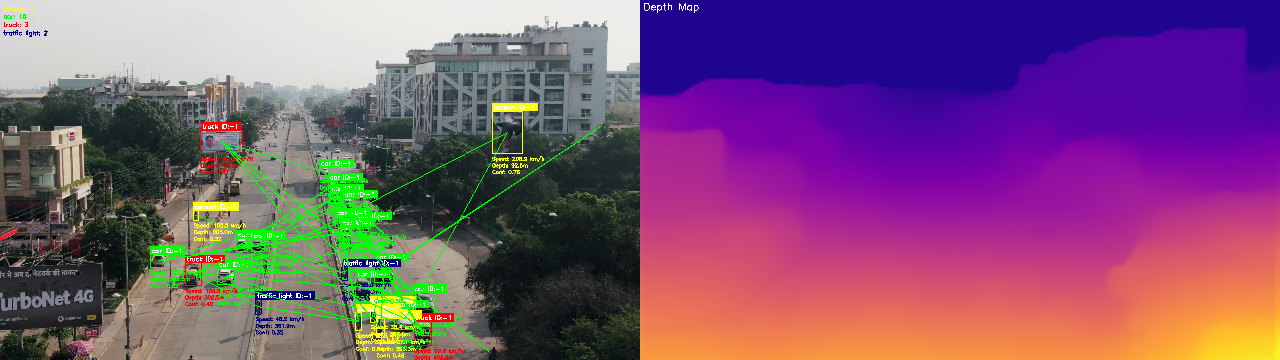


0: 384x640 3 persons, 15 cars, 3 trucks, 1 traffic light, 3207.9ms
Speed: 4.4ms preprocess, 3207.9ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


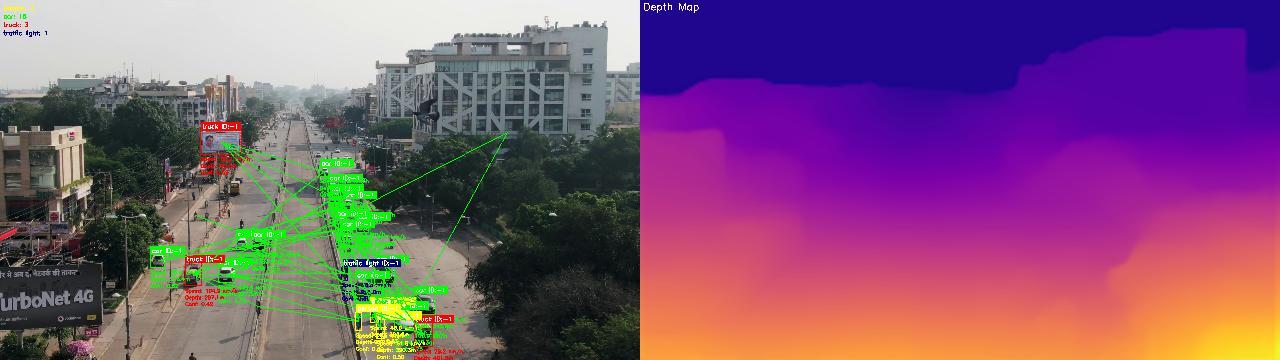


0: 384x640 3 persons, 15 cars, 3 trucks, 1 bird, 2789.7ms
Speed: 7.9ms preprocess, 2789.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Error during processing: 'unknown'

Processing complete
Outputs saved:
- processed_combined.mp4
- depth_map.mp4
- output_frames/
- depth_maps/


In [1]:
# Initial setup and imports
!pip install torch torchvision ultralytics timm
!pip install -q opencv-python matplotlib gdown

# Install MiDaS properly
!git clone https://github.com/isl-org/MiDaS.git
!pip install -q -r MiDaS/requirements.txt

import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time
import os
import sys

# Add MiDaS to Python path
sys.path.append('./MiDaS')

# Download the video using gdown
!gdown --id 12e8OlHSJ4B1PXDSKxUkDA6hHYUpV5UMV -O aerial_traffic.mp4

# COCO class names for traffic analysis
COCO_CLASSES = {
    0: 'person',
    1: 'bicycle',
    2: 'car',
    3: 'motorcycle',
    4: 'airplane',
    5: 'bus',
    6: 'train',
    7: 'truck',
    8: 'boat',
    9: 'traffic light',
    10: 'fire hydrant'
}

# Colors for different classes (BGR format)
COLORS = {
    'person': (0, 255, 255),     # Yellow
    'car': (0, 255, 0),          # Green
    'bus': (255, 0, 0),          # Blue
    'truck': (0, 0, 255),        # Red
    'motorcycle': (255, 255, 0),  # Cyan
    'bicycle': (255, 0, 255),     # Magenta
    'traffic light': (128, 0, 0), # Dark Blue
    'default': (128, 128, 128)    # Gray
}

class AerialTrafficDetector:
    def __init__(self):
        # Initialize YOLO with better model
        self.yolo_model = YOLO('yolov8x.pt')

        try:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Using device: {self.device}")

            # Load MiDaS model
            model_type = "MiDaS_small"
            self.midas = torch.hub.load("intel-isl/MiDaS", model_type)
            self.midas.to(self.device)
            self.midas.eval()

            # Load transforms
            self.midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            self.transform = self.midas_transforms.small_transform

        except Exception as e:
            print(f"Error initializing MiDaS: {str(e)}")
            raise

        self.previous_positions = {}
        self.track_history = {}
        self.previous_time = time.time()
        self.scale_factor = 0.2
        self.track_length = 30
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

    def get_color(self, class_name):
        return COLORS.get(class_name, COLORS['default'])

    def calculate_speed(self, current_pos, previous_pos, time_diff):
        if time_diff <= 0:
            return 0
        pixel_distance = np.sqrt(
            (current_pos[0] - previous_pos[0])**2 +
            (current_pos[1] - previous_pos[1])**2
        )
        meters = pixel_distance * self.scale_factor
        return (meters / time_diff) * 3.6  # Convert to km/h

    def update_trajectory(self, obj_id, center, class_name):
        if obj_id not in self.track_history:
            self.track_history[obj_id] = {'positions': [], 'class': class_name}
        self.track_history[obj_id]['positions'].append(center)
        if len(self.track_history[obj_id]['positions']) > self.track_length:
            self.track_history[obj_id]['positions'].pop(0)

    def draw_trajectory(self, frame, obj_id):
        if obj_id in self.track_history and len(self.track_history[obj_id]['positions']) > 1:
            points = np.array(self.track_history[obj_id]['positions'], dtype=np.int32)
            class_name = self.track_history[obj_id]['class']
            color = self.get_color(class_name)
            cv2.polylines(frame, [points], False, color, 2)

    def process_frame(self, frame):
        current_time = time.time()

        # Reset class counts
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

        # YOLO Detection
        results = self.yolo_model(frame, conf=0.3)

        # Depth Estimation
        input_batch = self.transform(frame).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        # Normalize depth map for visualization
        depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        depth_colormap = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

        # Create annotated frame
        annotated_frame = frame.copy()

        # Create combined visualization
        combined_frame = np.zeros((frame.shape[0], frame.shape[1]*2, 3), dtype=np.uint8)
        combined_frame[:, :frame.shape[1]] = annotated_frame
        combined_frame[:, frame.shape[1]:] = depth_colormap

        # Add depth map title
        cv2.putText(combined_frame,
                   'Depth Map',
                   (frame.shape[1] + 10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   1.0, (255, 255, 255), 2)

        # Process detections
        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

                obj_id = int(box.id) if box.id is not None else -1
                conf = float(box.conf)
                cls_id = int(box.cls)
                class_name = COCO_CLASSES.get(cls_id, 'unknown')

                # Update class counts
                self.class_counts[class_name] += 1

                # Get color for this class
                color = self.get_color(class_name)

                # Calculate speed
                speed = 0
                if obj_id in self.previous_positions:
                    prev_pos = self.previous_positions[obj_id]
                    time_diff = current_time - self.previous_time
                    speed = self.calculate_speed(center, prev_pos, time_diff)

                # Update tracking
                self.previous_positions[obj_id] = center
                self.update_trajectory(obj_id, center, class_name)
                self.draw_trajectory(combined_frame, obj_id)

                # Get depth for object
                obj_depth = np.mean(depth_map[int(y1):int(y2), int(x1):int(x2)])

                # Draw bounding box and label
                cv2.rectangle(combined_frame,
                            (int(x1), int(y1)),
                            (int(x2), int(y2)),
                            color, 2)

                # Create label background
                label = f'{class_name} ID:{obj_id}'
                (label_w, label_h), _ = cv2.getTextSize(label,
                                                       cv2.FONT_HERSHEY_SIMPLEX,
                                                       0.6, 2)
                cv2.rectangle(combined_frame,
                            (int(x1), int(y1) - label_h - 10),
                            (int(x1) + label_w + 10, int(y1)),
                            color, -1)

                # Add label text
                cv2.putText(combined_frame,
                           label,
                           (int(x1) + 5, int(y1) - 5),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.6, (255, 255, 255), 2)

                # Add additional information
                info_text = [
                    f'Speed: {speed:.1f} km/h',
                    f'Depth: {obj_depth:.1f}m',
                    f'Conf: {conf:.2f}'
                ]

                for i, text in enumerate(info_text):
                    cv2.putText(combined_frame,
                              text,
                              (int(x1), int(y2) + 20 + (i * 20)),
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.5, color, 2)

        # Add class counts
        y_offset = 30
        x_offset = 10
        for cls_name, count in self.class_counts.items():
            if count > 0:
                color = self.get_color(cls_name)
                label = f'{cls_name}: {count}'
                cv2.putText(combined_frame,
                           label,
                           (x_offset, y_offset),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.6, color, 2)
                y_offset += 25

                if y_offset > 150:
                    y_offset = 30
                    x_offset += 200

        self.previous_time = current_time
        return combined_frame, depth_colormap

def save_frame(frame, frame_count, prefix="frame"):
    """Save individual frames for analysis"""
    if frame_count % 30 == 0:  # Save every 30th frame
        filename = f"{prefix}_{frame_count}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Saved {filename}")

def process_video(video_path):
    try:
        detector = AerialTrafficDetector()
    except Exception as e:
        print(f"Error creating detector: {str(e)}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {frame_width}x{frame_height} @ {fps}fps")

    # Create output directories
    os.makedirs('output_frames', exist_ok=True)
    os.makedirs('depth_maps', exist_ok=True)

    # Create video writers
    out_combined = cv2.VideoWriter('processed_combined.mp4',
                                 cv2.VideoWriter_fourcc(*'mp4v'),
                                 fps,
                                 (frame_width * 2, frame_height))

    out_depth = cv2.VideoWriter('depth_map.mp4',
                               cv2.VideoWriter_fourcc(*'mp4v'),
                               fps,
                               (frame_width, frame_height))

    frame_count = 0
    processing_interval = 2  # Process every 2nd frame

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % processing_interval != 0:
                continue

            # Process frame
            combined_frame, depth_colormap = detector.process_frame(frame)

            # Write frames
            out_combined.write(combined_frame)
            out_depth.write(depth_colormap)

            # Save periodic frames
            if frame_count % 30 == 0:
                save_frame(combined_frame, frame_count, "output_frames/combined")
                save_frame(depth_colormap, frame_count, "depth_maps/depth")

            # Display progress
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Processing: {progress:.1f}% complete")

            # Display frame
            display_frame = cv2.resize(combined_frame, (1280, 360))
            cv2_imshow(display_frame)

            if frame_count % 10 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"Error during processing: {str(e)}")

    finally:
        cap.release()
        out_combined.release()
        out_depth.release()
        cv2.destroyAllWindows()
        print("\nProcessing complete")
        print("Outputs saved:")
        print("- processed_combined.mp4")
        print("- depth_map.mp4")
        print("- output_frames/")
        print("- depth_maps/")

# Main execution
if __name__ == "__main__":
    video_path = 'aerial_traffic.mp4'

    # Verify video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        exit()

    # Check GPU availability
    print("GPU Available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU Device:", torch.cuda.get_device_name(0))

    print(f"\nStarting video processing: {video_path}")
    try:
        process_video(video_path)
    except Exception as e:
        print(f"Error during video processing: {str(e)}")

In [4]:
import cv2
import torch
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow

def process_video(video_path, skip_frames=2, batch_size=1):
    cap = None
    out = None
    output_path = None

    try:
        # Load MiDaS with error handling
        try:
            midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
            midas.eval()
            if torch.cuda.is_available():
                midas.to('cuda')
            transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
        except Exception as e:
            print(f"Error loading MiDaS model: {e}")
            return

        # First, upload the video file
        print("Please upload your video file...")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded")
            return

        # Get the filename of the uploaded file
        video_path = next(iter(uploaded))
        print(f"Processing video: {video_path}")

        # Check if video file exists
        if not os.path.exists(video_path):
            print(f"Error: Video file not found at path: {video_path}")
            return

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file: {video_path}")
            return

        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Create output path
        output_path = 'depth_grayscale.mp4'

        # Create video writer
        out = cv2.VideoWriter(output_path,
                             cv2.VideoWriter_fourcc(*'mp4v'),
                             fps // skip_frames,
                             (frame_width, frame_height),
                             isColor=False)

        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % skip_frames != 0:
                continue

            try:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Transform frame
                input_batch = transform(frame_rgb)
                if torch.cuda.is_available():
                    input_batch = input_batch.to('cuda')

                # Depth estimation
                with torch.no_grad():
                    prediction = midas(input_batch)
                    prediction = torch.nn.functional.interpolate(
                        prediction.unsqueeze(1),
                        size=(frame_height, frame_width),
                        mode="bicubic",
                        align_corners=False,
                    ).squeeze()

                # Convert to grayscale depth map
                depth_map = prediction.cpu().numpy()
                depth_grayscale = np.uint8(255 * (depth_map - depth_map.min()) /
                                        (depth_map.max() - depth_map.min()))

                # Write frame
                out.write(depth_grayscale)

                # Display progress
                if frame_count % 30 == 0:
                    print(f"Processed {frame_count} frames")
                    cv2_imshow(depth_grayscale)
                    from IPython.display import clear_output
                    clear_output(wait=True)

                # Memory cleanup
                del prediction, depth_map
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error processing frame {frame_count}: {e}")
                continue

    except Exception as e:
        print(f"Error during processing: {e}")

    finally:
        # Cleanup
        if cap is not None:
            cap.release()
        if out is not None:
            out.release()
        cv2.destroyAllWindows()
        if output_path and os.path.exists(output_path):
            print(f"Processing complete. Output saved to: {output_path}")
            # Download the processed video
            files.download(output_path)
        else:
            print("Processing complete, but no output file was created.")

# Call the function
process_video(None, skip_frames=4)  # No need to specify path as we'll upload the file

Processing complete. Output saved to: depth_grayscale.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import cv2
import torch
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow
from collections import deque
import time

def process_video(video_path, buffer_size=5, process_interval=5, target_fps=12):
    cap = None
    out = None
    output_path = None

    try:
        # Load MiDaS with error handling - Using larger model for better resolution
        try:
            midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")  # Using full model instead of small
            midas.eval()
            if torch.cuda.is_available():
                midas.to('cuda')
            transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform  # Using default transform
        except Exception as e:
            print(f"Error loading MiDaS model: {e}")
            return

        # Upload and process video
        print("Please upload your video file...")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded")
            return

        video_path = next(iter(uploaded))
        print(f"Processing video: {video_path}")

        # Initialize video capture
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file: {video_path}")
            return

        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        original_fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Create FIFO buffer
        frame_buffer = deque(maxlen=buffer_size)

        # Create output path
        output_path = 'depth_grayscale_high_res.mp4'

        # Create video writer with target FPS
        out = cv2.VideoWriter(output_path,
                             cv2.VideoWriter_fourcc(*'mp4v'),
                             target_fps,
                             (frame_width, frame_height),
                             isColor=False)

        frame_count = 0
        processed_count = 0
        last_time = time.time()

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            frame_buffer.append(frame)

            # Process every nth frame (where n = process_interval)
            if frame_count % process_interval == 0:
                try:
                    # Convert BGR to RGB
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    # Apply enhanced preprocessing
                    input_batch = transform(frame_rgb)
                    if torch.cuda.is_available():
                        input_batch = input_batch.to('cuda')

                    # Depth estimation with enhanced post-processing
                    with torch.no_grad():
                        prediction = midas(input_batch)
                        prediction = torch.nn.functional.interpolate(
                            prediction.unsqueeze(1),
                            size=(frame_height, frame_width),
                            mode="bicubic",
                            align_corners=False,
                        ).squeeze()

                    # Enhanced depth map processing
                    depth_map = prediction.cpu().numpy()

                    # Apply contrast enhancement
                    depth_min = np.percentile(depth_map, 2)  # Remove outliers
                    depth_max = np.percentile(depth_map, 98)
                    depth_map = np.clip(depth_map, depth_min, depth_max)

                    # Convert to grayscale with enhanced contrast
                    depth_grayscale = np.uint8(255 * (depth_map - depth_map.min()) /
                                            (depth_map.max() - depth_map.min()))

                    # Apply adaptive histogram equalization
                    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                    depth_grayscale = clahe.apply(depth_grayscale)

                    # Write frame
                    out.write(depth_grayscale)
                    processed_count += 1

                    # Calculate and maintain target FPS
                    current_time = time.time()
                    elapsed = current_time - last_time
                    if elapsed < 1.0/target_fps:
                        time.sleep(1.0/target_fps - elapsed)
                    last_time = time.time()

                    # Display progress
                    if processed_count % 10 == 0:
                        print(f"Processed {processed_count} frames")
                        print(f"Current FPS: {1.0/elapsed:.2f}")
                        cv2_imshow(depth_grayscale)
                        from IPython.display import clear_output
                        clear_output(wait=True)

                    # Memory cleanup
                    del prediction, depth_map
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error processing frame {frame_count}: {e}")
                    continue

    except Exception as e:
        print(f"Error during processing: {e}")

    finally:
        # Cleanup
        if cap is not None:
            cap.release()
        if out is not None:
            out.release()
        cv2.destroyAllWindows()
        if output_path and os.path.exists(output_path):
            print(f"Processing complete. Output saved to: {output_path}")
            print(f"Total frames processed: {processed_count}")
            print(f"Processing ratio: 1:{process_interval}")
            # Download the processed video
            files.download(output_path)
        else:
            print("Processing complete, but no output file was created.")

# Call the function with optimized parameters
process_video(None,
             buffer_size=5,        # Size of FIFO buffer
             process_interval=5,   # Process every 5th frame
             target_fps=12)        # Target output FPS

Processing complete. Output saved to: depth_grayscale_high_res.mp4
Total frames processed: 364
Processing ratio: 1:5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import cv2
import torch
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow
from collections import deque
import time

def apply_colormap(depth_map):
    """Convert depth map to RGB colormap"""
    # Normalize depth map
    depth_min = np.percentile(depth_map, 2)
    depth_max = np.percentile(depth_map, 98)
    depth_map = np.clip(depth_map, depth_min, depth_max)
    depth_map = ((depth_map - depth_min) / (depth_max - depth_min) * 255).astype(np.uint8)

    # Apply colormap (you can try different colormaps)
    # Options: cv2.COLORMAP_PLASMA, cv2.COLORMAP_MAGMA, cv2.COLORMAP_VIRIDIS, cv2.COLORMAP_TURBO
    colored_depth = cv2.applyColorMap(depth_map, cv2.COLORMAP_TURBO)
    return colored_depth

def process_video(video_path, buffer_size=5, process_interval=5, target_fps=12):
    cap = None
    out = None
    output_path = None

    try:
        # Load MiDaS
        try:
            midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
            midas.eval()
            if torch.cuda.is_available():
                midas.to('cuda')
            transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform
        except Exception as e:
            print(f"Error loading MiDaS model: {e}")
            return

        print("Please upload your video file...")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded")
            return

        video_path = next(iter(uploaded))
        print(f"Processing video: {video_path}")

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file: {video_path}")
            return

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        original_fps = int(cap.get(cv2.CAP_PROP_FPS))

        frame_buffer = deque(maxlen=buffer_size)

        # Changed output filename and set isColor to True for RGB
        output_path = 'depth_rgb.mp4'
        out = cv2.VideoWriter(output_path,
                             cv2.VideoWriter_fourcc(*'mp4v'),
                             target_fps,
                             (frame_width, frame_height),
                             isColor=True)  # Set to True for RGB

        frame_count = 0
        processed_count = 0
        last_time = time.time()

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            frame_buffer.append(frame)

            if frame_count % process_interval == 0:
                try:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    input_batch = transform(frame_rgb)
                    if torch.cuda.is_available():
                        input_batch = input_batch.to('cuda')

                    with torch.no_grad():
                        prediction = midas(input_batch)
                        prediction = torch.nn.functional.interpolate(
                            prediction.unsqueeze(1),
                            size=(frame_height, frame_width),
                            mode="bicubic",
                            align_corners=False,
                        ).squeeze()

                    depth_map = prediction.cpu().numpy()

                    # Convert depth map to RGB
                    colored_depth = apply_colormap(depth_map)

                    # Optional: Add depth visualization enhancements
                    # 1. Add contours
                    depth_gray = cv2.cvtColor(colored_depth, cv2.COLOR_BGR2GRAY)
                    edges = cv2.Canny(depth_gray, 100, 200)
                    colored_depth = cv2.addWeighted(colored_depth, 1.0, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.2, 0)

                    # 2. Enhance contrast
                    colored_depth = cv2.convertScaleAbs(colored_depth, alpha=1.1, beta=0)

                    # Write colored frame
                    out.write(colored_depth)
                    processed_count += 1

                    current_time = time.time()
                    elapsed = current_time - last_time
                    if elapsed < 1.0/target_fps:
                        time.sleep(1.0/target_fps - elapsed)
                    last_time = time.time()

                    if processed_count % 10 == 0:
                        print(f"Processed {processed_count} frames")
                        print(f"Current FPS: {1.0/elapsed:.2f}")
                        cv2_imshow(colored_depth)
                        from IPython.display import clear_output
                        clear_output(wait=True)

                    del prediction, depth_map
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error processing frame {frame_count}: {e}")
                    continue

    except Exception as e:
        print(f"Error during processing: {e}")

    finally:
        if cap is not None:
            cap.release()
        if out is not None:
            out.release()
        cv2.destroyAllWindows()
        if output_path and os.path.exists(output_path):
            print(f"Processing complete. Output saved to: {output_path}")
            print(f"Total frames processed: {processed_count}")
            files.download(output_path)
        else:
            print("Processing complete, but no output file was created.")

# Call the function
process_video(None, buffer_size=5, process_interval=5, target_fps=12)

Processing complete. Output saved to: depth_rgb.mp4
Total frames processed: 364


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>